# Intro in PyTorch, DevOps, R&D in Deep Learning

    В данном семинаре мы познакомимся с pytorch на примере задачи классификации.

## CIFAR10 and PyTorch

In [11]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

    Одна из важных комнонент пайплайна обучения нейронных сетей -- это данные.
    В pytorch в зависимости от задачи есть несколько стадий. В данном случае у нас есть
    предобработка картинок в виде `transform`, чтение картинок `torchvision.datasets.CIFAR10` и сборка
    картинок в батч `torch.utils.data.DataLoader`.

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                               shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

test_dataloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                              shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


    Посмотрим на один батч картинок

In [21]:
%pylab inline

from itertools import islice

Populating the interactive namespace from numpy and matplotlib


In [26]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

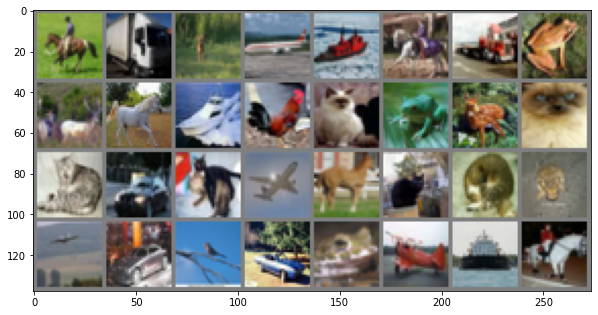

In [66]:
images, _ = list(islice(train_dataloader, 1))[0]

plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(images))

    Следующая компанента это сама модель. Для примера просто возьмем сеть из туториал.

In [29]:
from torch import nn
import torch.nn.functional as F


class Reshape(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        # X.shape == [B, C, H, W] -> [B, H']
        return torch.flatten(x, start_dim=1)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            Reshape(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
            nn.Linear(84, 10),
        )
        
    def forward(self, x):
        return self.net(x)


net = Net()
device = torch.device('cpu')
net = net.to(device)
net = net.train()

    Определяем функцию потерь и метод оптимизации

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,
                      nesterov=True, weight_decay=1e-5)

    И последняя компанента пайплайна это написание train/val loop-ов. В данном случае тут все просто, но
    в больших задачах эта часть занимает много времени и кода :( Стоит присмотреться в библиотекам, которые
    это делают за нас, например, pytorch-lighting

In [31]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.176
[1,  4000] loss: 1.829
[1,  6000] loss: 1.653
[1,  8000] loss: 1.563
[1, 10000] loss: 1.518
[1, 12000] loss: 1.439
[2,  2000] loss: 1.373
[2,  4000] loss: 1.328
[2,  6000] loss: 1.313
[2,  8000] loss: 1.266
[2, 10000] loss: 1.269
[2, 12000] loss: 1.257
Finished Training


    Посмотрим качество классификации на одном тестовом батче

In [54]:
images, _ = list(islice(test_dataloader, 1))[0]

with torch.no_grad():
    logits = net(images)
    predicted_labels = torch.argmax(logits, dim=1)

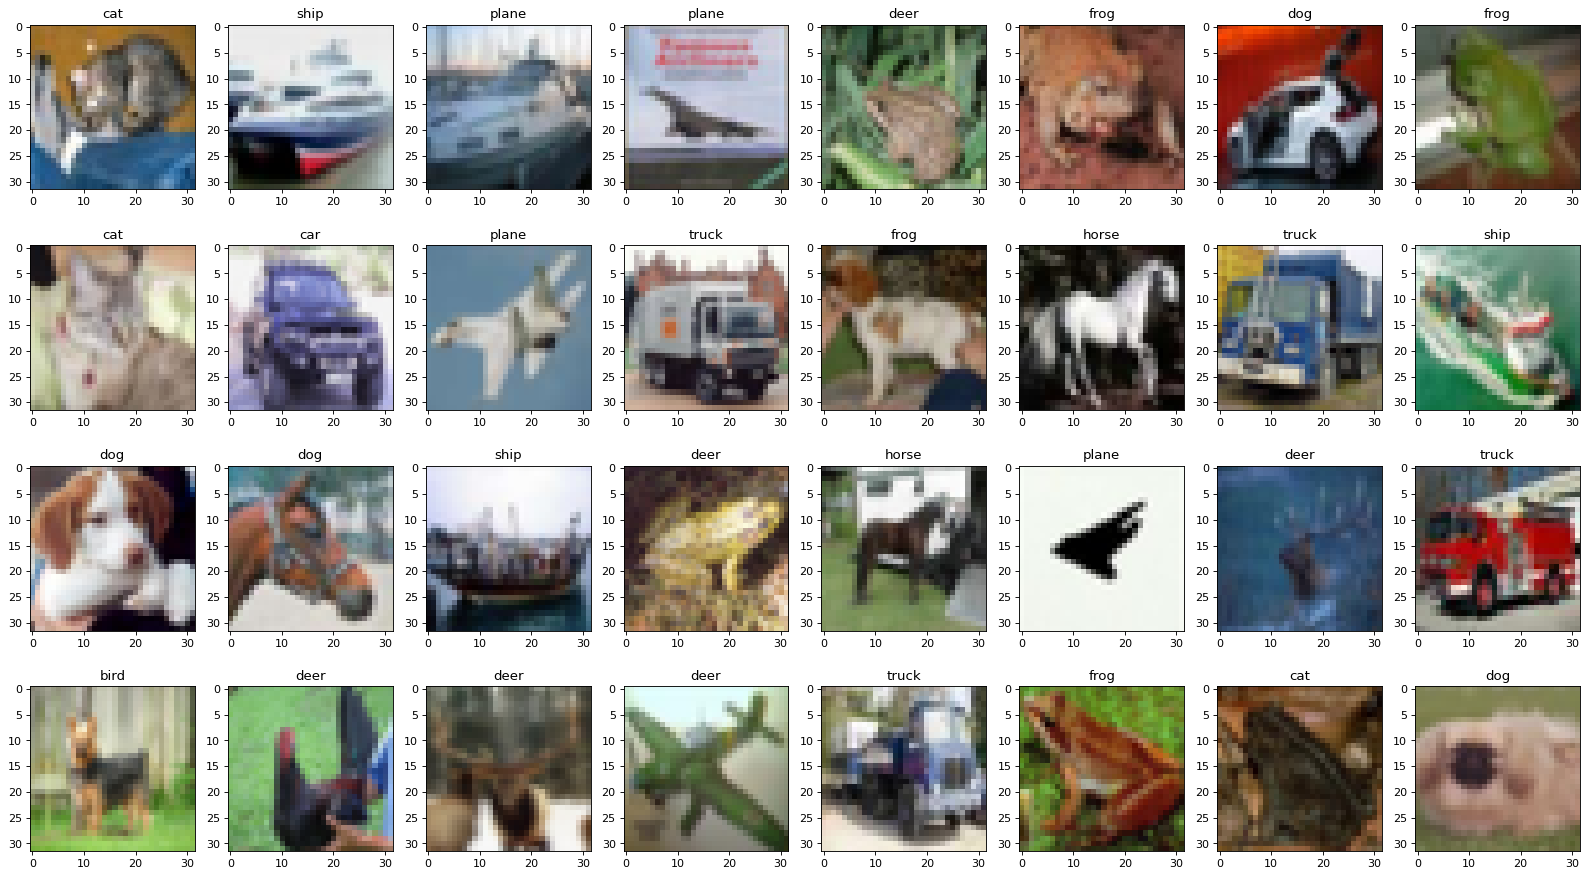

In [63]:
_, axes = plt.subplots(4, 8, figsize=(25, 14), dpi=80)
axes = axes.flatten()

for ax, image, label in zip(axes, images, predicted_labels):
    image = image / 2 + 0.5
    image = image.permute(1, 2, 0)
    
    ax.set_title(classes[label.item()])
    ax.imshow(image)
    
plt.show()

# torchaudio

    Немного познакомимся с torchaudio -- аналог torchvision, но для звука. torchaudio предоставляется возможность считать
    STFT (short-time Fourier transform), Spectrograms, MelSpectrograms, а также много чего еще.

In [84]:
import torchaudio
from scipy.signal import hann
from scipy.io import wavfile

    Считаем wav файл и посмотрим как он выглядит

In [69]:
filename = "audio.wav"
waveform, sample_rate = torchaudio.load(filename)

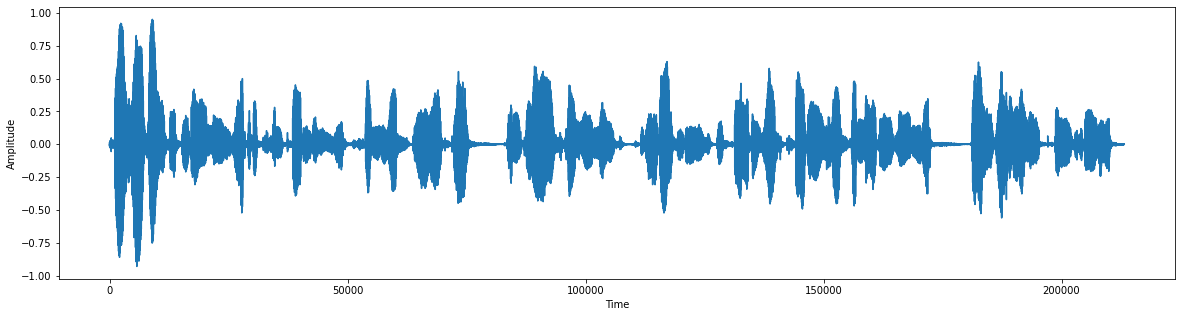

In [75]:
plt.figure(figsize=(20, 5))
plt.plot(waveform.squeeze())
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Short-time Fourier transform
    Посмотрим на STFT из коборки. Всмомним, что STFT из себя представлят нарезанием аудио на окна с каким то шагом,
    применением оконной функции, а потом применением преобразования Фурье.

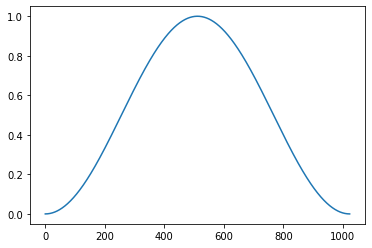

In [103]:
window = hann(1024)
plt.plot(window)
plt.show()

In [89]:
freqs = torch.stft(
    input=waveform,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    window=torch.from_numpy(window),
    center=False
)

    Чтобы избавиться от комлексной плоскости мы берем норму (p==2) по последней размерности.

In [122]:
spectrograms = torch.norm(freqs, 2, -1)

    Если присмотреться -- можно увидеть белые пятна

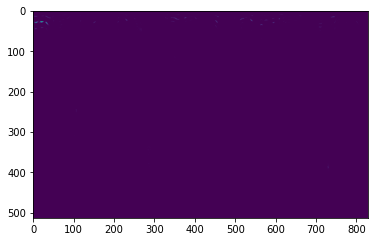

In [127]:
plt.imshow(spectrograms.squeeze())

# Spectrograms

Shape of spectrogram: torch.Size([1, 513, 833])


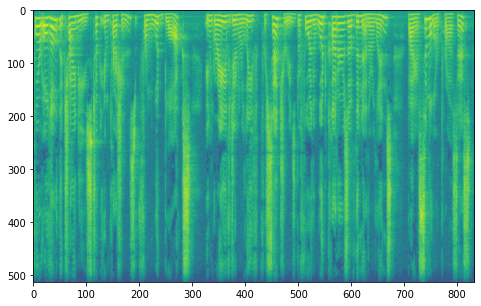

In [132]:
spectrogramer = torchaudio.transforms.Spectrogram(
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    power=2.0,
)

spectrogram = spectrogramer(waveform)

print("Shape of spectrogram: {}".format(spectrogram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(np.log(spectrogram.squeeze()))
plt.show()

# MelSpectrograms

Shape of spectrogram: torch.Size([1, 80, 833])


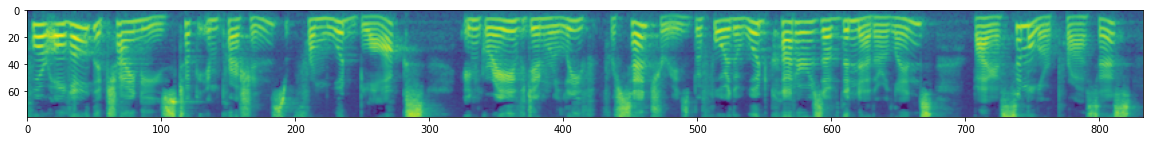

In [135]:
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=80,
)

mel_spectrogram = mel_spectrogramer(waveform)

print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(torch.log(mel_spectrogram.squeeze()))
plt.show()